# Module 1: Flash Unit
In this module, we will familiarize ourselves with the IDAES framework by creating and working with a flowsheet that contains a single flash tank. The flash tank will be used to perform separation of Benzene and Toluene. The inlet specifications for this flash tank are:

Inlet Specifications:
* Mole fraction (Benzene) = 0.5
* Mole fraction (Toluene) = 0.5
* Pressure = 101325 Pa
* Temperature = 368 K

We will complete the following tasks:
* Create the model and the IDAES Flowsheet object
* Import the appropriate property packages
* Create the flash unit and set the operating conditions
* Initialize the model and simulate the system
* Demonstrate analyses on this model through some examples and exercises

## Key links to documentation
* Main IDAES online documentation page: https://idaes-pse.readthedocs.io/en/latest/index.html
* Core IDAES Library: https://idaes-pse.readthedocs.io/en/latest/core/index.html
    * Flowsheet: https://idaes-pse.readthedocs.io/en/latest/core/flowsheet_model.html
    * Property Packages: https://idaes-pse.readthedocs.io/en/latest/core/properties.html
    * Unit Model: https://idaes-pse.readthedocs.io/en/latest/core/unit_model.html
* Modeling Standards: https://idaes-pse.readthedocs.io/en/latest/standards.html
    * Naming Conventions: https://idaes-pse.readthedocs.io/en/latest/standards.html#standard-naming-format
* IDAES Unit Model Library: https://idaes-pse.readthedocs.io/en/latest/model_libraries/core_library/unit_models/index.html

## Create the Model and the IDAES Flowsheet

In the next cell, we will perform the necessary imports to get us started. From `pyomo.environ` (a standard import for the Pyomo package), we are importing `ConcreteModel` (to create the Pyomo model that will contain the IDAES flowsheet) and `SolverFactory` (to create the object we will use to solve the equations). We will also import `Constraint` as we will be adding a constraint to the model later in the module. Lastly, we also import `value` from Pyomo. This is a function that can be used to return the current numerical value for variables and parameters in the model. These are all part of Pyomo.

We will also import the main `FlowsheetBlock` from IDAES. The flowsheet block will contain our unit model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below to perform the imports. Let a workshop organizer know if you see any errors.
</div>

In [1]:
from pyomo.environ import ConcreteModel, SolverFactory, Constraint, value
from idaes.core import FlowsheetBlock

# Import idaes logger to set output levels
import idaes.logger as idaeslog

In the next cell, we will create the `ConcreteModel` and the `FlowsheetBlock`, and attach the flowsheet block to the Pyomo model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below to create the objects
</div>

In [2]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})

At this point, we have a single Pyomo model that contains an (almost) empty flowsheet block.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Use the pprint method on the model, i.e. m.pprint(), to see what is currently contained in the model.
</div>

In [3]:
# Todo: call pprint on the model
m.pprint()

1 Block Declarations
    fs : Size=1, Index=None, Active=True
        1 Set Declarations
            time : Size=1, Index=None, Ordered=Insertion
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    1 :  {0.0,}

        1 Declarations: time

1 Declarations: fs


## Define Properties

We need to define the property package for our flowsheet. In this example, we will be using the ideal property package that is available as part of the IDAES framework. This property package supports ideal gas - ideal liquid, ideal gas - NRTL, and ideal gas - Wilson models for VLE. More details on this property package can be found at: https://idaes-pse.readthedocs.io/en/latest/model_libraries/core_library/property_models/activity_coefficient.html

IDAES also supports creation of your own property packages that allow for specification of the fluid using any set of valid state variables (e.g., component molar flows vs overall flow and mole fractions). This flexibility is designed to support advanced modeling needs that may rely on specific formulations. To learn about creating your own property package, please consult the online documentation at: https://idaes-pse.readthedocs.io/en/latest/core/properties.html and look at examples within IDAES

For this workshop, we will import the BTX_activity_coeff_VLE property parameter block to be used in the flowsheet. This properties block will be passed to our unit model to define the appropriate state variables and equations for performing thermodynamic calculations.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the following two cells to import and create the properties block.
</div>

In [4]:
from idaes.generic_models.properties.activity_coeff_models.BTX_activity_coeff_VLE \
    import BTXParameterBlock

In [5]:
m.fs.properties = BTXParameterBlock(default={"valid_phase": ('Liq', 'Vap'),
                                            "activity_coeff_model": "Ideal",
                                            "state_vars": "FTPz"})

## Adding Flash Unit

Now that we have the flowsheet and the properties defined, we can create the flash unit and add it to the flowsheet. 

**The Unit Model Library within IDAES includes a large set of common unit operations (see the online documentation for details: https://idaes-pse.readthedocs.io/en/latest/model_libraries/core_library/unit_models/index.html**

IDAES also fully supports the development of customized unit models (which we will see in a later module).

Some of the IDAES pre-written unit models:
* Mixer / Splitter
* Heater / Cooler
* Heat Exchangers (simple and 1D discretized)
* Flash
* Reactors (kinetic, equilibrium, gibbs, stoichiometric conversion)
* Pressure changing equipment (compressors, expanders, pumps)
* Feed and Product (source / sink) components

In this module, we will import the `Flash` unit model from `idaes.generic_models.unit_models` and create an instance of the flash unit, attaching it to the flowsheet. Each IDAES unit model has several configurable options to customize the model behavior, but also includes defaults for these options. In this example, we will specify that the property package to be used with the Flash is the one we created earlier.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the following two cells to import the Flash and create an instance of the unit model, attaching it to the flowsheet object.
</div>

In [6]:
from idaes.generic_models.unit_models import Flash

In [7]:
m.fs.flash = Flash(default={"property_package": m.fs.properties})

At this point, we have created a flowsheet and a properties block. We have also created a flash unit and added it to the flowsheet. Under the hood, IDAES has created the required state variables and model equations. Everything is open. You can see these variables and equations by calling the Pyomo method `pprint` on the model, flowsheet, or flash tank objects. Note that this output is very exhaustive, and is not intended to provide any summary information about the model, but rather a complete picture of all of the variables and equations in the model.

## Set Operating Conditions

Now that we have created our unit model, we can specify the necessary operating conditions. It is often very useful to determine the degrees of freedom before we specify any conditions.

The `idaes.core.util.model_statistics` package has a function `degrees_of_freedom`. To see how to use this function, we can make use of the Python function `help(func)`. This function prints the appropriate documentation string for the function.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Import the degrees_of_freedom function and print the help for the function by calling the Python help function.
</div>

In [8]:
# Todo: import the degrees_of_freedom function from the idaes.core.util.model_statistics package
from idaes.core.util.model_statistics import degrees_of_freedom

# Todo: Call the python help on the degrees_of_freedom function
help(degrees_of_freedom)

Help on function degrees_of_freedom in module idaes.core.util.model_statistics:

degrees_of_freedom(block)
    Method to return the degrees of freedom of a model.
    
    Args:
        block : model to be studied
    
    Returns:
        Number of degrees of freedom in block.



<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Now print the degrees of freedom for your model. The result should be 7.
</div>

In [9]:
# Todo: print the degrees of freedom for your model
print("Degrees of Freedom =", degrees_of_freedom(m))

Degrees of Freedom = 7


In [10]:
# Check the degrees of freedom
assert degrees_of_freedom(m) == 7

To satisfy our degrees of freedom, we will first specify the inlet conditions. We can specify these values through the `inlet` port of the flash unit.

**To see the list of naming conventions for variables within the IDAES framework, consult the online documentation at: https://idaes-pse.readthedocs.io/en/latest/standards.html#standard-naming-format**

As an  example, to fix the molar flow of the inlet to be 1.0, you can use the following notation:
```python
m.fs.flash.inlet.flow_mol.fix(1.0)
```

To specify variables that are indexed by components, you can use the following notation:
```python
m.fs.flash.inlet.mole_frac_comp[0, "benzene"].fix(0.5)
```

<div class="alert alert-block alert-warning">
<b>Note:</b>
The "0" in the indexing of the component mole fraction is present because IDAES models support both dynamic and steady state simulation, and the "0" refers to a timestep. Dynamic modeling is beyond the scope of this workshop. Since we are performing steady state modeling, there is only a single timestep in the model.
</div>

In the next cell, we will specify the inlet conditions. To satisfy the remaining degrees of freedom, we will make two additional specifications on the flash tank itself. The names of the key variables within the Flash unit model can also be found in the online documentation: https://idaes-pse.readthedocs.io/en/latest/model_libraries/core_library/unit_models/flash.html#variables.


To specify the value of a variable on the unit itself, use the following notation.

```python
m.fs.flash.heat_duty.fix(0)
```

For this module, we will use the following specifications:
* inlet overall molar flow = 1.0 (`flow_mol`)
* inlet temperature = 368 K (`temperature`)
* inlet pressure = 101325 Pa (`pressure`)
* inlet mole fraction (benzene) = 0.5 (`mole_frac_comp[0, "benzene"]`)
* inlet mole fraction (toluene) = 0.5 (`mole_frac_comp[0, "toluene"]`)
* The heat duty on the flash set to 0 (`heat_duty`)
* The pressure drop across the flash tank set to 0 (`deltaP`)

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Write the code below to specify the inlet conditions and unit specifications described above
</div>

In [11]:
# Inlet specifications given above
m.fs.flash.inlet.flow_mol.fix(1)
m.fs.flash.inlet.temperature.fix(368)
m.fs.flash.inlet.pressure.fix(101325)
m.fs.flash.inlet.mole_frac_comp[0, "benzene"].fix(0.5)
m.fs.flash.inlet.mole_frac_comp[0, "toluene"].fix(0.5)

# Todo: add code for the 2 flash unit specifications given above
m.fs.flash.heat_duty.fix(0)
m.fs.flash.deltaP.fix(0)

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Check the degrees of freedom again to ensure that the system is now square. You should see that the degrees of freedom is now 0.
</div>

In [12]:
# Todo: print the degrees of freedom for your model
print("Degrees of Freedom =", degrees_of_freedom(m))

Degrees of Freedom = 0


In [13]:
# Check the degrees of freedom 
assert degrees_of_freedom(m) == 0

## Initializing the Model

IDAES includes pre-written initialization routines for all unit models. You can call this initialize method on the units. In the next module, we will demonstrate the use of a sequential modular solve cycle to initialize flowsheets.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Call the initialize method on the flash unit to initialize the model.
</div>

In [14]:
# Todo: initialize the flash unit
m.fs.flash.initialize(outlvl=idaeslog.INFO)

2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 1 optimal - Optimal Solution Found.
2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 2 optimal - Optimal Solution Found.
2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 3 optimal - Optimal Solution Found.
2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 4 optimal - Optimal Solution Found.
2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.properties_in: Initialization Step 5 optimal - Optimal Solution Found.
2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 1 optimal - Optimal Solution Found.
2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.properties_out: Initialization Step 2 optimal - Optimal Solution Found.
2020-06-01 19:47:57 [INFO] idaes.init.fs.flash.control_volume.prope

Now that the model has been defined and intialized, we can solve the model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Using the notation described in the previous model, create an instance of the "ipopt" solver and use it to solve the model. Set the tee option to True to see the log output.
</div>

In [15]:
# Todo: create the ipopt solver
solver = SolverFactory('ipopt')

# Todo: solve the model
status = solver.solve(m, tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [16]:
# Check for optimal solution
from pyomo.environ import TerminationCondition
assert status.solver.termination_condition == TerminationCondition.optimal

## Viewing the Results

Once a model is solved, the values returned by the solver are loaded into the model object itself. We can access the value of any variable in the model with the `value` function. For example:
```python
print('Vap. Outlet Temperature = ', value(m.fs.flash.vap_outlet.temperature[0]))
```

You can also find more information about a variable or an entire port using the `display` method from Pyomo:
```python
m.fs.flash.vap_outlet.temperature.display()
m.fs.flash.vap_outlet.display()
```

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cells below to show the current value of the flash vapor outlet pressure. This cell also shows use of the display function to see the values of the variables in the vap_outlet and the liq_outlet.
</div>

In [17]:
# Print the pressure of the flash vapor outlet
print('Pressure =', value(m.fs.flash.vap_outlet.pressure[0]))

print()
print('Output from display:')
# Call display on vap_outlet and liq_outlet of the flash
m.fs.flash.vap_outlet.display()
m.fs.flash.liq_outlet.display()

Pressure = 101325.0

Output from display:
vap_outlet : Size=1
    Key  : Name           : Value
    None :       flow_mol : {0.0: 0.39611817487742085}
         : mole_frac_comp : {(0.0, 'benzene'): 0.6339766485081284, (0.0, 'toluene'): 0.3660233514918713}
         :       pressure : {0.0: 101325.0}
         :    temperature : {0.0: 368.0}
liq_outlet : Size=1
    Key  : Name           : Value
    None :       flow_mol : {0.0: 0.6038818251225793}
         : mole_frac_comp : {(0.0, 'benzene'): 0.41211759772293016, (0.0, 'toluene'): 0.5878824022770697}
         :       pressure : {0.0: 101325.0}
         :    temperature : {0.0: 368.0}


The output from `display` is quite exhaustive and not really intended to provide quick summary information. Because Pyomo is built on Python, there are opportunities to format the output any way we like. Most IDAES models have a `report` method which provides a summary of the results for the model.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below which uses the function above to print a summary of the key variables in the flash model, including the inlet, the vapor, and the liquid ports.  
</div>

In [18]:
m.fs.flash.report()


Unit : fs.flash                                                            Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Duty : 0.0000 :  True : (None, None)
    Pressure Change : 0.0000 :  True : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000      0.39612       0.60388  
    mole_frac_comp benzene    0.50000      0.63398       0.41212  
    mole_frac_comp toluene    0.50000      0.36602       0.58788  
    temperature                368.00       368.00        368.00  
    pressure               1.0132e+05   1.0132e+05    1.0132e+05  


In [19]:
# Check optimal solution values
import pytest

assert value(m.fs.flash.liq_outlet.flow_mol[0]) == pytest.approx(0.6038, abs=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, 'benzene']) == pytest.approx(0.4121, abs=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, 'toluene']) == pytest.approx(0.5878, abs=1e-3)
assert value(m.fs.flash.liq_outlet.temperature[0]) == pytest.approx(368, abs=1e-3)
assert value(m.fs.flash.liq_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)

assert value(m.fs.flash.vap_outlet.flow_mol[0]) == pytest.approx(0.3961, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, 'benzene']) == pytest.approx(0.6339, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, 'toluene']) == pytest.approx(0.3660, abs=1e-3)
assert value(m.fs.flash.vap_outlet.temperature[0]) == pytest.approx(368, abs=1e-3)
assert value(m.fs.flash.vap_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)

## Studying Purity as a Function of Heat Duty

Since the entire modeling framework is built upon Python, it includes a complete programming environment for whatever analysis we may want to perform. In this next exercise, we will make use of what we learned in this and the previous module to generate a figure showing some output variables as a function of the heat duty in the flash tank.

First, let's import the matplotlib package for plotting as we did in the previous module.
<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Execute the cell below to import matplotlib appropriately.
</div>

In [20]:
import matplotlib.pyplot as plt

Exercise specifications:
* Generate a figure showing the flash tank heat duty (`m.fs.flash.heat_duty[0]`) vs. the vapor flowrate (`m.fs.flash.vap_outlet.flow_mol[0]`)
* Specify the heat duty from -17000 to 25000 over 50 steps

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Using what you have learned so far, fill in the missing code below to generate the figure specified above. (Hint: import numpy and use the linspace function from the previous module)
</div>

Simulating with Q =  -17000.0
... solve successful.
Simulating with Q =  -16142.857142857143
... solve successful.
Simulating with Q =  -15285.714285714286
... solve successful.
Simulating with Q =  -14428.571428571428
... solve successful.
Simulating with Q =  -13571.428571428572
... solve successful.
Simulating with Q =  -12714.285714285714
... solve successful.
Simulating with Q =  -11857.142857142857
... solve successful.
Simulating with Q =  -11000.0
... solve successful.
Simulating with Q =  -10142.857142857143
... solve successful.
Simulating with Q =  -9285.714285714286
... solve successful.
Simulating with Q =  -8428.57142857143
... solve successful.
Simulating with Q =  -7571.4285714285725
... solve successful.
Simulating with Q =  -6714.285714285714
... solve successful.
Simulating with Q =  -5857.142857142857
... solve successful.
Simulating with Q =  -5000.0
... solve successful.
Simulating with Q =  -4142.857142857143
... solve successful.
Simulating with Q =  -3285.71428

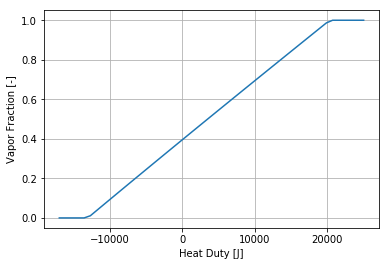

In [21]:
# import the solve_successful checking function from workshop tools
from workshoptools import solve_successful

# Todo: import numpy
import numpy as np

# create the empty lists to store the results that will be plotted
Q = []
V = []

# create the solver
solver = SolverFactory('ipopt')

# Todo: Write the for loop specification using numpy's linspace
for duty in np.linspace(-17000, 25000, 50):
    # fix the heat duty
    m.fs.flash.heat_duty.fix(duty)
    
    # append the value of the duty to the Q list
    Q.append(duty)
    
    # print the current simulation
    print("Simulating with Q = ", value(m.fs.flash.heat_duty[0]))

    # Solve the model
    status = solver.solve(m)
    
    # append the value for vapor fraction if the solve was successful
    if solve_successful(status):
        V.append(value(m.fs.flash.vap_outlet.flow_mol[0]))
        print('... solve successful.')
    else:
        V.append(0.0)
        print('... solve failed.')
    
# Create and show the figure
plt.figure("Vapor Fraction")
plt.plot(Q, V)
plt.grid()
plt.xlabel("Heat Duty [J]")
plt.ylabel("Vapor Fraction [-]")
plt.show()

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Repeate the exercise above, but create a figure showing the heat duty vs. the mole fraction of Benzene in the vapor outlet. Remove any unnecessary printing to create cleaner results.
</div>

Simulating with Q =  -17000.0
... solve successful.
Simulating with Q =  -16142.857142857143
... solve successful.
Simulating with Q =  -15285.714285714286
... solve successful.
Simulating with Q =  -14428.571428571428
... solve successful.
Simulating with Q =  -13571.428571428572
... solve successful.
Simulating with Q =  -12714.285714285714
... solve successful.
Simulating with Q =  -11857.142857142857
... solve successful.
Simulating with Q =  -11000.0
... solve successful.
Simulating with Q =  -10142.857142857143
... solve successful.
Simulating with Q =  -9285.714285714286
... solve successful.
Simulating with Q =  -8428.57142857143
... solve successful.
Simulating with Q =  -7571.4285714285725
... solve successful.
Simulating with Q =  -6714.285714285714
... solve successful.
Simulating with Q =  -5857.142857142857
... solve successful.
Simulating with Q =  -5000.0
... solve successful.
Simulating with Q =  -4142.857142857143
... solve successful.
Simulating with Q =  -3285.71428

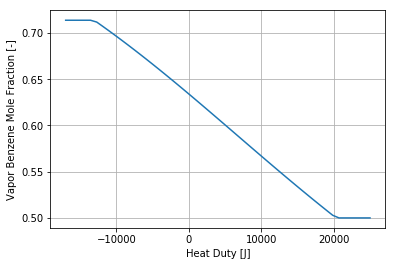

In [22]:
# Todo: generate a figure of heat duty vs. mole fraction of Benzene in the vapor
Q = []
V = []

m.fs.flash.heat_duty.fix(0)

m.fs.flash.initialize(outlvl=idaeslog.WARNING)

for duty in np.linspace(-17000, 25000, 50):
    # fix the heat duty
    m.fs.flash.heat_duty.fix(duty)
    
    # append the value of the duty to the Q list
    Q.append(duty)
    
    # print the current simulation
    print("Simulating with Q = ", value(m.fs.flash.heat_duty[0]))
    
    # solve the model
    status = solver.solve(m)
    
    # append the value for vapor fraction if the solve was successful
    if solve_successful(status):
        V.append(value(m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"]))
        print('... solve successful.')
    else:
        V.append(0.0)
        print('... solve failed.')
    
plt.figure("Purity")
plt.plot(Q, V)
plt.grid()
plt.xlabel("Heat Duty [J]")
plt.ylabel("Vapor Benzene Mole Fraction [-]")
plt.show()


Recall that the IDAES framework is an equation-oriented modeling environment. This means that we can specify "design" problems natively. That is, there is no need to have our specifications on the inlet alone. We can put specifications on the outlet as long as we retain a well-posed, square system of equations.

For example, we can remove the specification on heat duty and instead specify that we want the mole fraction of Benzene in the vapor outlet to be equal to 0.6. The mole fraction is not a native variable in the property block, so we cannot use "fix". We can, however, add a constraint to the model.

Note that we have been executing a number of solves on the problem, and may not be sure of the current state. To help convergence, therefore, we will first call initialize, then add the new constraint and solve the problem. Note that the reference for the mole fraction of Benzene in the vapor outlet is `m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"]`.

<div class="alert alert-block alert-info">
<b>Inline Exercise:</b>
Fill in the missing code below and add a constraint on the mole fraction of Benzene (to a value of 0.6) to find the required heat duty.
</div>


In [23]:
# re-initialize the model - this may or may not be required depending on current state but safe to initialize
m.fs.flash.heat_duty.fix(0)
m.fs.flash.initialize(outlvl=idaeslog.WARNING)

# Unfix the heat_duty variable
m.fs.flash.heat_duty.unfix()

# Todo: Add a new constraint (benzene mole fraction to 0.6)
m.benz_purity_con = Constraint(expr= m.fs.flash.vap_outlet.mole_frac_comp[0, "benzene"] == 0.6)

# solve the problem
status = solver.solve(m, tee=True)

# Check stream condition
m.fs.flash.report()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [24]:
# Check for solver status
assert status.solver.termination_condition == TerminationCondition.optimal

# Check for optimal values
assert value(m.fs.flash.liq_outlet.flow_mol[0]) == pytest.approx(0.4516, abs=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, 'benzene']) == pytest.approx(0.3786, abs=1e-3)
assert value(m.fs.flash.liq_outlet.mole_frac_comp[0, 'toluene']) == pytest.approx(0.6214, abs=1e-3)
assert value(m.fs.flash.liq_outlet.temperature[0]) == pytest.approx(369.07, abs=1e-2)
assert value(m.fs.flash.liq_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)

assert value(m.fs.flash.vap_outlet.flow_mol[0]) == pytest.approx(0.5483, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, 'benzene']) == pytest.approx(0.6, abs=1e-3)
assert value(m.fs.flash.vap_outlet.mole_frac_comp[0, 'toluene']) == pytest.approx(0.4, abs=1e-3)
assert value(m.fs.flash.vap_outlet.temperature[0]) == pytest.approx(369.07, abs=1e-2)
assert value(m.fs.flash.vap_outlet.pressure[0]) == pytest.approx(101325, abs=1e-3)